In [2]:
from fl_clientlib import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import model_from_json
from keras.optimizers import Adam
import datetime

In [3]:
img_path = input("Enter image or dataframe.csv path\n")
data_frame = load(img_path, verbose=10000)

Enter image or dataframe.csv path
C:/Users/ecourt/Desktop/Data Set
['C:/Users/ecourt/Desktop/Data Set\\dataframe.csv']


In [4]:
data_frame.head()

,Unnamed: 0,Image,Covid,Normal
0,0,C:/Users/ecourt/Desktop/Data Set\0\NORMAL (1).png,0.0,1.0
1,1,C:/Users/ecourt/Desktop/Data Set\0\NORMAL (10)...,0.0,1.0
2,2,C:/Users/ecourt/Desktop/Data Set\0\NORMAL (100...,0.0,1.0
3,3,C:/Users/ecourt/Desktop/Data Set\0\NORMAL (100...,0.0,1.0
4,4,C:/Users/ecourt/Desktop/Data Set\0\NORMAL (100...,0.0,1.0


In [5]:
data_frame.tail()

,Unnamed: 0,Image,Covid,Normal
1555,1555,C:/Users/ecourt/Desktop/Data Set\1\COVID-19(21...,1.0,0.0
1556,1556,C:/Users/ecourt/Desktop/Data Set\1\COVID-19(21...,1.0,0.0
1557,1557,C:/Users/ecourt/Desktop/Data Set\1\COVID-19(21...,1.0,0.0
1558,1558,C:/Users/ecourt/Desktop/Data Set\1\COVID-19(21...,1.0,0.0
1559,1559,C:/Users/ecourt/Desktop/Data Set\1\COVID-19(21...,1.0,0.0


In [6]:
train_df, valid_df, test_df = \
              np.split(data_frame.sample(frac=1, random_state=42), 
                       [int(.8*len(data_frame)), int(.9*len(data_frame))])
labels = ['Covid', 'Normal']

In [7]:
IMAGE_DIR = ""#To be replaced
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

x, y = train_generator.__getitem__(0)
v, w = valid_generator.__getitem__(0)
print(v[0].shape)
print(x[0].shape)

getting train generator...
Found 1248 validated image filenames.
getting train and valid generators...
Found 1248 validated image filenames.
Found 156 validated image filenames.
Found 156 validated image filenames.
(32, 32, 1)
(32, 32, 1)


    Class     Label    Value
0   Covid  Positive  0.11532
1  Normal  Positive  0.11532
2   Covid  Negative  0.11532
3  Normal  Negative  0.11532


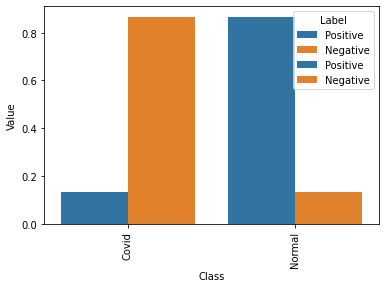

In [8]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);
print(data.head())

In [9]:
steps_per_epoch = train_generator.labels.shape[0]//train_generator.batch_size
validation_steps = valid_generator.labels.shape[0]//valid_generator.batch_size

In [10]:
sio = socketio.Client()

class Flnamespace(socketio.ClientNamespace):

    def get_weighted_loss(self, pos_weights, neg_weights, epsilon=1e-7):
        def weighted_loss(y_true, y_pred):
            loss = 0.0
            for i in range(len(pos_weights)):
                # for each class, add average weighted loss for that class 
                loss += -(K.mean( pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon) + \
                                    neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon), axis = 0))
            return loss
        return weighted_loss

    def train_model(self, server_packet):
        model = server_packet["model"]
        n_round = server_packet["n_round"]
        if(n_round==1):
            self.model = model_from_json(model)
            self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        else:
            
            model = pickle_string_to_obj(model)
            print(len(model))
            print(model[0].shape)
            self.model.set_weights(model)
            n_round = server_packet["n_round"]
            
        
        
        print("Preparing to train model")
        
        print(f"===Round {n_round}===")
        start = datetime.datetime.now()
        history = self.model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch = steps_per_epoch,#steps_per_epoch, 
                              validation_steps = validation_steps,#validation_steps, 
                              epochs = 10)

        end = datetime.datetime.now()

        c = end - start
        minutes = divmod(c.seconds, 60)  
        print('Training time: ', minutes[0], 'minutes', 
                                        minutes[1], 'seconds') 

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.legend(["loss", "val_loss"])
        plt.xlabel("epoch")
        plt.title("Loss Curve")
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.legend(["accuracy", "binary_accuracy"])
        plt.xlabel("epoch")
        plt.title("Accuracy Curve")
        plt.show()
        
        predicted_vals = self.model.predict(test_generator, steps = len(test_generator))
    
        cm = confusion_matrix(test_generator.labels[:,0], predicted_vals[:,0].round())
        sns.heatmap(cm/np.sum(cm), annot = True, fmt='0.2%', cmap = 'Blues')

    
        weights = self.model.get_weights()
        
        score = self.model.evaluate(test_generator, verbose=0)
        print("Model trained and new weights are being sent to server")
    
    
        sio.emit("complete_round", {"weights": obj_to_pickle_string(weights), "n_train": train_generator.labels.shape[0], "n_test": test_generator.labels.shape[0], "scores": score, "n_round": n_round}, callback=self.train_model)

    def on_connect(self):
        print("Server connected")
        sio.emit("model_request", {})

    def on_sending_model(self, server_packet):
        print("Client receiving model")
        self.train_model(server_packet)

    def on_disconnect(self):
        print("Server disconnected")

class Flclient():

    def __init__(self):
        
        sio.register_namespace(Flnamespace())

    def start(self, url):
        sio.connect(url)
        sio.wait()

    def stop(self):
        sio.disconnect()


In [11]:
fl_client = Flclient()
url = input("Enter the server's url\n")

Enter the server's url
http://127.0.0.1:5000


In [12]:
pixels = x.flatten()
flat_y = y.flatten()
n_pix_per_im = x.shape[0]*x.shape[1]
n = pixels.shape[0]
pix_labels = [flat_y[i//n_pix_per_im] for i in range(n)]
mean_x = np.mean(pixels)
var_x = np.var(pixels)
std_x = np.std(pixels)
mean_y = np.mean(pix_labels)
var_y = np.var(pix_labels)
std_y = np.std(pix_labels)
m = np.corrcoef(pixels, pix_labels)[0, 1]*std_y/std_x
b = mean_y - m*mean_x
print(f"Variance: {var_x}")
print(f"Standard deviation: {std_x}")

Variance: 0.9999908804893494
Standard deviation: 0.9999954104423523


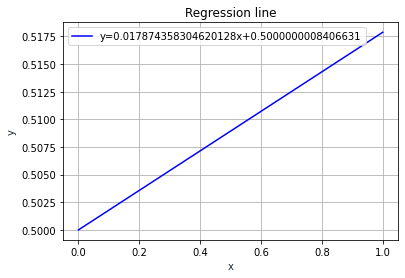

In [13]:
x_axis = np.linspace(0,1,100)
y_axis = m*x_axis + b
plt.plot(x_axis, y_axis, '-b', label=f'y={m}x+{b}')
plt.title('Regression line')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.grid()
plt.show()

Server connected
Client receiving model
Preparing to train model
===Round 1===
Epoch 1/10
32/32 [==============================] - 65s 2s/step - loss: 0.3631 - accuracy: 0.8251 - val_loss: 0.2436 - val_accuracy: 0.8906
Epoch 2/10
32/32 [==============================] - 36s 1s/step - loss: 0.1073 - accuracy: 0.9649 - val_loss: 0.1201 - val_accuracy: 0.9609
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.0625 - accuracy: 0.9812 - val_loss: 0.1315 - val_accuracy: 0.9531
Epoch 4/10
32/32 [==============================] - 39s 1s/step - loss: 0.0624 - accuracy: 0.9804 - val_loss: 0.0983 - val_accuracy: 0.9609
Epoch 5/10
32/32 [==============================] - 42s 1s/step - loss: 0.0362 - accuracy: 0.9866 - val_loss: 0.0905 - val_accuracy: 0.9531
Epoch 6/10
32/32 [==============================] - 46s 1s/step - loss: 0.0249 - accuracy: 0.9956 - val_loss: 0.1256 - val_accuracy: 0.9609
Epoch 7/10
32/32 [==============================] - 45s 1s/step - loss: 0.0259 - 

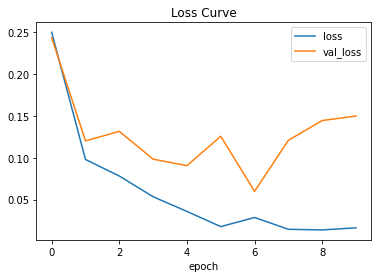

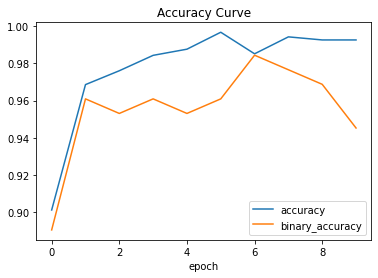

Model trained and new weights are being sent to server
Server disconnected


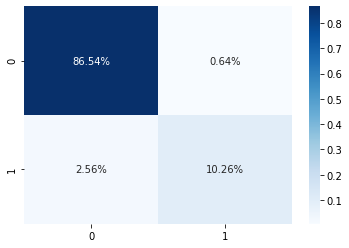

In [14]:
fl_client.start(url)

In [15]:
fl_client.stop()